<h1>Step 1: Importing the Libraries</h1>
As we all know, the first step is to import the libraries required to preprocess Microsoft Corporation stock data and the other libraries required for constructing and visualizing the LSTM model outputs. We’ll be using the Keras library from the TensorFlow framework for this. All modules are imported from the Keras library.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn import linear_model
from keras.models import Sequential, load_model
import keras.backend as K
from keras.callbacks import EarlyStopping
# from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

import pydot
import graphviz


</h1>Step 2: Import data from yfinance</h1>

In [2]:
#intro to yfinance
msft = yf.Ticker('MSFT')
data = msft.history(interval = '1m', period = '1d') #can't feed interval in second
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-11-15 15:55:00-05:00,415.579987,415.700012,415.480011,415.609985,142995,0.0,0.0
2024-11-15 15:56:00-05:00,415.605011,415.605011,415.160004,415.200012,118755,0.0,0.0
2024-11-15 15:57:00-05:00,415.190002,415.295013,414.899994,415.019989,144505,0.0,0.0
2024-11-15 15:58:00-05:00,415.040009,415.100006,414.950012,415.010010,191015,0.0,0.0
2024-11-15 15:59:00-05:00,415.019989,415.089996,414.670013,414.809998,601899,0.0,0.0


<h1>Step 3: Checking for Null Values by Printing the DataFrame Shape</h1>
</br>we’ll check for null values in the data frame to ensure that there are none. The existence of null values in the dataset causes issues during training since they function as outliers, creating a wide variance in the training process.

In [6]:
#data preprocessing
print("Null Value Present: ", data.isnull().values.any())


Null Value Present:  False


In [7]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-11-15 09:30:00-05:00,420.250000,422.679993,419.540009,421.480011,2573847,0.0,0.0
2024-11-15 09:31:00-05:00,421.515015,422.600006,421.420013,421.940002,66992,0.0,0.0
2024-11-15 09:32:00-05:00,421.839996,422.799988,421.760010,422.084991,73836,0.0,0.0
2024-11-15 09:33:00-05:00,422.049988,422.195007,421.609985,421.869995,90462,0.0,0.0
2024-11-15 09:34:00-05:00,421.846008,421.989990,420.880005,420.899994,268138,0.0,0.0


<h3>Step 5: Setting the Target Variable and Selecting the Features</h3>
</br>The output column is then assigned to the target variable in the following step. It is the adjusted relative value of Microsoft Stock in this situation. Furthermore, we pick the features that serve as the independent variable to the target variable (dependent variable). We choose four characteristics to account for training purposes:

Open
High
Low
Volume

In [8]:
output_var = pd.DataFrame(data['Close'])
features = ['Open','High','Low','Volume']

<h3>Step 6: Scaling</h3>
</br>To decrease the computational cost of the data in the table, we will scale the stock values to values between 0 and 1. As a result, all of the data in large numbers is reduced, and therefore memory consumption is decreased. Also, because the data is not spread out in huge values, we can achieve greater precision by scaling down. To perform this, we will be using the MinMaxScaler

In [9]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(data[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=data.index)
feature_transform.head()

,Open,High,Low,Volume
Datetime,,,,
2024-11-15 09:30:00-05:00,0.779413,0.986333,0.726601,1.000000
2024-11-15 09:31:00-05:00,0.934439,0.977223,0.958129,0.025203
2024-11-15 09:32:00-05:00,0.974266,1.000000,1.000000,0.027864
2024-11-15 09:33:00-05:00,1.000000,0.931096,0.981524,0.034329
2024-11-15 09:34:00-05:00,0.975002,0.907745,0.891625,0.103419


<h3>Step 7: Creating a Training Set and a Test Set for Stock Market Prediction</h3>
</br>Before inputting the entire dataset into the training model, we need to partition it into training and test sets. The Machine Learning LSTM model will undergo training using the data in the training set, and its accuracy and backpropagation will be tested against the test set.

To accomplish this, we will employ the TimeSeriesSplit class from the sci-kit-learn library. We will configure the number of splits to be 10, indicating that 10% of the data will serve as the test set, while the remaining 90% will train the LSTM model. The advantage of employing this Time Series split lies in its examination of data samples at regular time intervals.

In [10]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

<h3>Step 8: Data Processing For LSTM</h3>
</br>Once the training and test sets are finalized, we will input the data into the LSTM model. Before we can do that, we must transform the training and test set data into a format that the LSTM model can interpret. As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match the format (Number of Samples, 1, Number of Features). Now, 350 are the number of samples in the training set, which is 90% of 389, and the number of features is 4. Therefore, the training set is reshaped to reflect this (350, 1, 4). Likewise, the test set is reshaped.

In [11]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

<h3>Step 9: Building the LSTM Model for Stock Market Prediction</h3>
</br>Finally, we arrive at the point when we construct the LSTM Model. In this step, we’ll build a Sequential Keras model with one LSTM layer. The LSTM layer has 32 units and is followed by one Dense Layer of one neuron.

We compile the model using Adam Optimizer and the Mean Squared Error as the loss function. For an LSTM model, this is the most preferred combination. The model is plotted and presented below.

In [ ]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)


<h3>Step 10: Training the Stock Market Prediction Model</h3>
</br>Finally, we use the fit function to train the LSTM model created above on the training data for 100 epochs with a batch size of 8.

In [ ]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

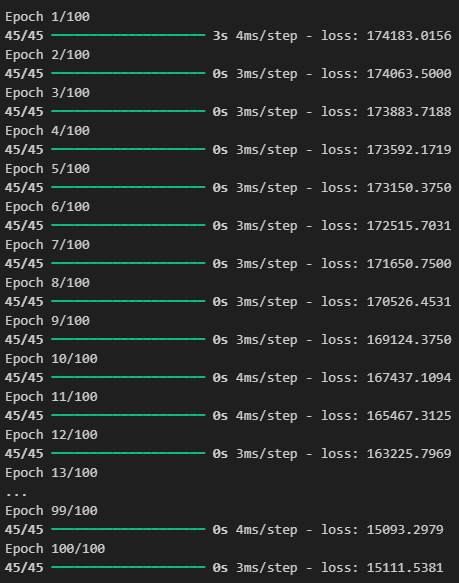

<h3>Step 11: Making the LSTM Prediction</h3>
</br>Now that we have our model ready, we can use it to forecast the Adjacent Close Value of the Microsoft stock by using a model trained using the LSTM network on the test set. We can accomplish this by employing simple prediction model on the LSTM model

In [ ]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

<h3>Step 12: Comparing Predicted vs True Adjusted Close Value – LSTM</h3>
</br>Finally, now that we’ve projected the values for the test set, we can display the graph to compare both close true values and close predicted value using the LSTM Machine Learning model.

In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

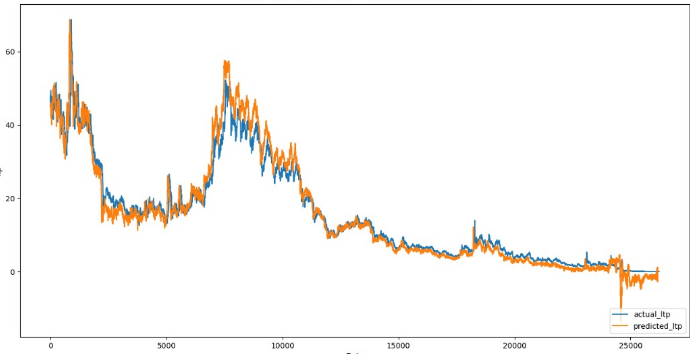